# Airbnb

## Setup

In [1]:
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import pandas as pd
import requests
import os
import numpy as np
import json
import qgrid
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../other/csv_files/listings.csv', na_values=['NA'])

## Exploration

### Airbnb Data Set
Scraped Nov 2018

All data is from Berlin Germany

### Show Data

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,2017-03-20,1.25,1,220
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,2018-08-16,0.39,1,297
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,2018-11-04,1.75,1,26


### Objective:  Successfully classify which neighbourhood the residence is in

Going to start by choosing a couple columns I think are most important, and filtering out
extreme outliers

**Columns used**
- Price
- Minimum nights
- Reviews per month
- Days per year available
- General neighborhood

**Values filtered out**
- Private rooms
- Places with min nights over 10
- Places with price over 250
- Availability less than 15
- Reviews per momth less than 10

In [4]:
# filter out private rooms, min nights > 10, price > 5000
filtered_df = df[(df.room_type == 'Entire home/apt') &
                 (df.price <= 150) &
                 (df.minimum_nights <= 6) &
                 (df.availability_365 >= 15) &
                 (df.reviews_per_month <= 5)]

In [5]:
# select just the columns I want
filtered_df = filtered_df[['price','minimum_nights', 'reviews_per_month', 'availability_365', 'neighbourhood_group']]

# droping rows with NaNs & duplicate rows
# inplace=True means the action is performed on itself, instead of a copy
filtered_df.dropna(inplace=True)
filtered_df.drop_duplicates(inplace=True)

# show filtered df
filtered_df.head()

,price,minimum_nights,reviews_per_month,availability_365,neighbourhood_group
0,60,4,3.76,141,Mitte
10,49,5,2.10,232,Neukölln
11,129,3,0.75,166,Pankow
13,98,3,0.59,257,Friedrichshain-Kreuzberg
17,90,4,0.05,15,Pankow


Hmmm...I wonder how many neighbourhoods there are?

This could be more difficult with lots of different neighborhoods, so we'll just choose the 4 with the most listings

In [6]:
filtered_df.groupby(['neighbourhood_group']).size()

neighbourhood_group
Charlottenburg-Wilm.        275
Friedrichshain-Kreuzberg    581
Lichtenberg                  72
Marzahn - Hellersdorf        44
Mitte                       591
Neukölln                    286
Pankow                      563
Reinickendorf                49
Spandau                      25
Steglitz - Zehlendorf        86
Tempelhof - Schöneberg      216
Treptow - Köpenick           92
dtype: int64

**Picking 3 that seem the most different. Oringal plan was to use the 4 with the most postings but they were all too similar**

In [7]:
#neighbourhoods = ['Mitte', 'Reinickendorf', 'Spandau']

neighbourhoods = ['Mitte', 'Friedrichshain-Kreuzberg', 'Pankow']

filtered_df = filtered_df[filtered_df.neighbourhood_group.isin(neighbourhoods)]

### Plotting the data

The seaborn package gives us a quick look at distributions for each feature, by neighborhood

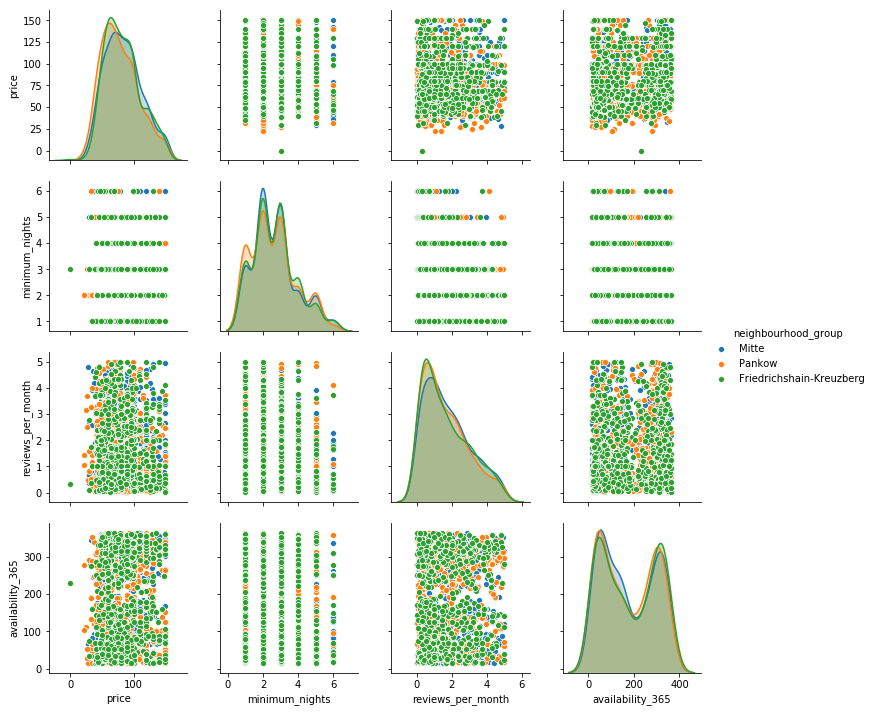

In [8]:
sb.pairplot(filtered_df, hue='neighbourhood_group')

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


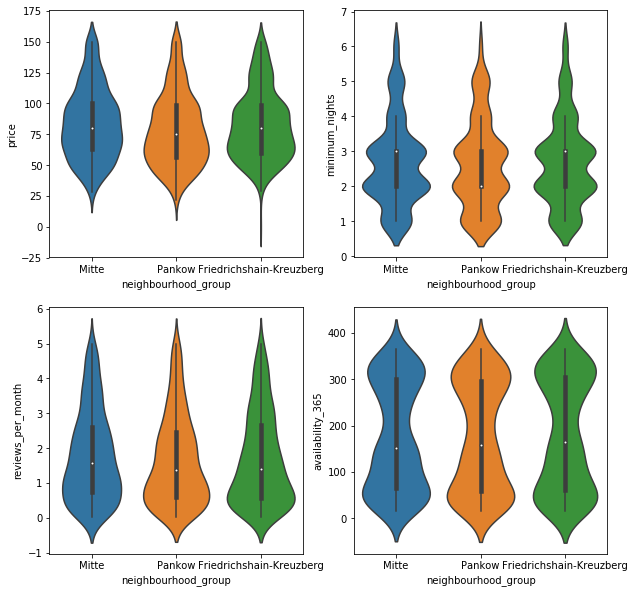

In [9]:
# violin plots are like box plot but show density
plt.figure(figsize=(10, 10))

for column_index, column in enumerate(filtered_df.columns):
    if column == 'neighbourhood_group':
        continue
    plt.subplot(2, 2, column_index + 1)
    sb.violinplot(x='neighbourhood_group', y=column, data=filtered_df)

Unfortunately, these each of the neighborhoods is very similar to the others. I think that this will make it a lot harder for any model to accurately classify the neighborhoods based on the features

### Classification

Going to be splitting the data into a test set and a training set

In [10]:
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
all_inputs = filtered_df[['price', 'minimum_nights',
                          'reviews_per_month', 'availability_365']].values

# Similarly, we can extract the class labels
all_labels = filtered_df['neighbourhood_group'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_labels[5]

# Here's what a subset of our inputs looks like:
all_inputs[:5]

array([[6.00e+01, 4.00e+00, 3.76e+00, 1.41e+02],
       [1.29e+02, 3.00e+00, 7.50e-01, 1.66e+02],
       [9.80e+01, 3.00e+00, 5.90e-01, 2.57e+02],
       [9.00e+01, 4.00e+00, 5.00e-02, 1.50e+01],
       [9.00e+01, 5.00e+00, 3.30e-01, 5.50e+01]])

Now we split the data for testing

In [11]:
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

Going to be using a decision tree classfier to start, with all default parameters

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.3986175115207373

This was just a one off though, whith the result depending on how we split & sampled our data.

Lets try to run it 1,000 times and look a the distribution of scores

''

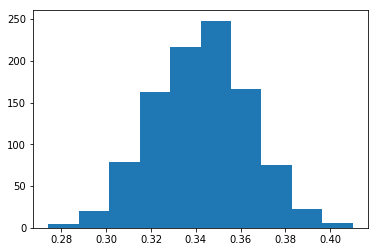

In [13]:
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
;

Unfortunately, the model performs with anywhere from 75% to 87% accurately, depending on the sample.

This could be a case of overfitting, where the model gets very good at handling the test input, but fails to accurately handle cases not present in the test input. However, I'm not 100% I have enough data for all neighborhoods to fix this.

This problem is the main reason that most data scientists perform k-fold cross-validation on their models: Split the original data set into k subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated k times such that each subset is used as the testing set exactly once.

10-fold cross-validation is the most common choice

''

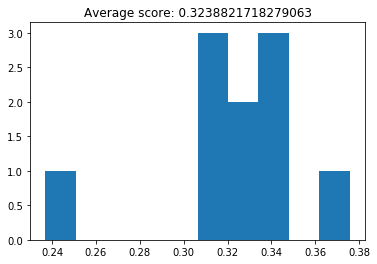

In [14]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

#### Improving the Model

Most machine learning models have different paramters that can be tuned to increate the effectiveness of the model. If we limit the depth of our decision tree, for example, we can see that our model changes in performance.

My orginal guess was that limiting the decision tree depth to one would make the model less accurate, but it actually improved the accuracy!

''

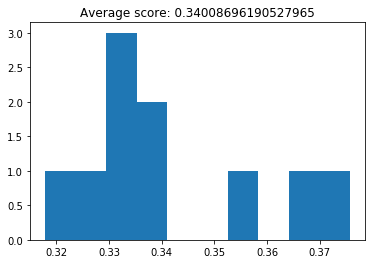

In [15]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

Ideally, we could systematically have the computer discover the best parameters to in the model.

To do this we can use grid search.

For now, we will focus on just two features

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.3585014409221902
Best parameters: {'max_depth': 2, 'max_features': 4}


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Visualizing the grid search to see how the parameters interact...

''

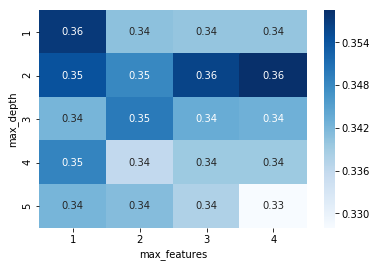

In [17]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

It looks like the number of features doesn't make a difference in accuracy (which I find suprising), and having a depth of 1 also makes the model slightly more accurate (which I also find suprsing).

Now we can go ahead and use grid search again, but this time to find the best of a broader list of parameters

In [18]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.37694524495677234
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 2, 'splitter': 'best'}


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


We can now use the best parameters for our decision tree classifier in our model going forward

In [19]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Next, lets plot the performance of our new and improved model

''

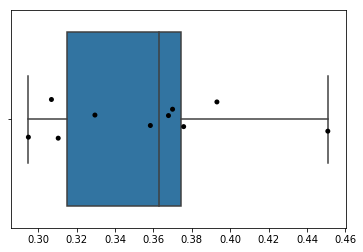

In [20]:
dt_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)

sb.boxplot(dt_scores)
sb.stripplot(dt_scores, jitter=True, color='black')
;

We can now try out a Random Forest classifier, which uses many decision trees. This should help reduce overfitting of the data.

In [21]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.34755043227665705
Best parameters: {'criterion': 'gini', 'max_features': 4, 'n_estimators': 10}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Random forest is not much more accurate, given that we only have 4 features, its probably a bit overkill. We now plot the perfomance of the decision tree against the random forest to see the differences.

''

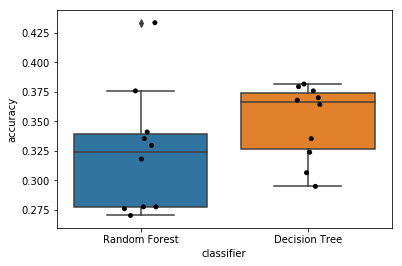

In [22]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

To sum things up, we'll run the model once more, and print some sample classifications

[119.     3.     3.15 234.  ]	-->	Friedrichshain-Kreuzberg	(Actual: Friedrichshain-Kreuzberg)
[ 98.     2.     3.15 332.  ]	-->	Friedrichshain-Kreuzberg	(Actual: Friedrichshain-Kreuzberg)
[79.    1.    0.88 54.  ]	-->	Mitte	(Actual: Pankow)
[109.     1.     4.62  25.  ]	-->	Mitte	(Actual: Pankow)
[ 90.     1.     2.21 322.  ]	-->	Mitte	(Actual: Pankow)
[90.    3.    0.82 20.  ]	-->	Friedrichshain-Kreuzberg	(Actual: Friedrichshain-Kreuzberg)
[59.    4.    0.95 67.  ]	-->	Friedrichshain-Kreuzberg	(Actual: Mitte)
[ 60.     2.     0.65 219.  ]	-->	Pankow	(Actual: Friedrichshain-Kreuzberg)
[48.    3.    2.96 81.  ]	-->	Friedrichshain-Kreuzberg	(Actual: Pankow)
[50.    2.    3.86 46.  ]	-->	Mitte	(Actual: Mitte)


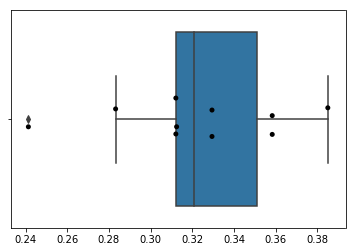

In [23]:
# All that's left to do now is plot the cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10)
sb.boxplot(rf_classifier_scores)
sb.stripplot(rf_classifier_scores, jitter=True, color='black')

# ...and show some of the predictions from the classifier
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)

random_forest_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              random_forest_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))